In [32]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import json
import os

import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
from geoalchemy2 import Geometry, WKTElement

# Data Cleaning and Uploading Data to pgAdmin

In the section below, we are cleaning all our files including:
1.  Neighbourhoods.csv
2.  BusinessStats.csv
3.  StatisticalAreas.csv
4.  RFSNSW_BFPL.shp
5.  SA2_2016_AUST.shp
6.  RFSStation_EPSG4326.json (additional dataset)

Methods for cleaning data includes:

- checkNull(dataset, beenCleaned): check if there's a null value
- removeNull(dataset): drop the null value in the dataset

** For each dataset, we also check the type of different columns to see if they are in their correct type. If they're not, then we convert them. For instance, all population values are intially string, but we convert them into numeric values.


In [4]:
# Function use to check if null values exist in the dataset. If there's null value, we'll drop the row to increase 
# accuracy in our calculations.

def checkNull( dataset ):
    
    beenCleaned = False    
    
    for num in list(dataset.isnull().sum()):

        if num != 0:
            print("Null value found. Coverted null values to ...")
            dataset = dataset.dropna() #found null, drop the row
            beenCleaned = True
            
    if beenCleaned:
        print("\nNull values have been removed. You're good to go!")

    else:
        print("\nNo null values in. Good to go, no need for cleaning :)")

    return dataset

In [5]:
#Connecting to pgAdmin

data_path = "."

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        HOST       = db_conn_dict['host']
        DB_USER    = db_conn_dict['user']
        DB_PW      = db_conn_dict['password']
        DEFAULT_DB = db_conn_dict['user']

        try:
            db = create_engine('postgres+psycopg2://'+DB_USER+':'+DB_PW+'@'+HOST+'/'+DEFAULT_DB, echo=False)
            conn = db.connect()
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
            
        return db,conn

credfilepath = os.path.join(data_path, "data2x02_db.json")
db, conn = pgconnect(credfilepath)


connected


## Cleaning StatisticalAreas.csv and Uploading it

In [7]:
rawData = pd.read_csv("StatisticalAreas.csv")

#Check if contains NULL
cleanData = checkNull(rawData)

#Cleaning data so that only numeric values are included in area_id
if cleanData['area_id'].dtypes != int:
    print("\nUpdated area_id data type from " + str(cleanData['area_id'].dtypes) + " to integer & removed data with wrong type")
    cleanData = cleanData[cleanData.area_id.str.isnumeric()]
    cleanData['area_id'].astype(int)

#Cleaning data so that only numeric values are included in parent_area_id
if cleanData['parent_area_id'].dtypes != int:
    print("\nUpdated area_id data type from " + str(cleanData['parent_area_id'].dtypes) + " to integer & removed data with wrong type")
    cleanData = cleanData[cleanData.parent_area_id.str.isnumeric()]
    cleanData['parent_area_id'].astype(int)

statisticalAreas_clean = cleanData

#Uploading StatisticalAreas.csv to pgAdmin

conn.execute("DROP TABLE IF EXISTS statisticalareas")

statistical_areas = """CREATE TABLE IF NOT EXISTS statisticalareas (
                         area_id   Integer PRIMARY KEY,
                         area_name VARCHAR(20),
                         parent_area_id Integer
                   )"""
conn.execute(statistical_areas)
print("\nSuccessfully, created table for statistical areas...")

table_name = "statisticalareas"
statisticalAreas_clean.to_sql(table_name, con=conn, if_exists='replace',index=False)
print ("\nUploaded clean statistical areas data to pgAdmin")
res = pd.read_sql_query("SELECT * FROM statisticalareas",conn)
res


No null values in. Good to go, no need for cleaning :)

Successfully, created table for statistical areas...

Uploaded clean statistical areas data to pgAdmin


,area_id,area_name,parent_area_id
0,1,New South Wales,0
1,10,Greater Sydney,1
2,11,Rest of NSW,1
3,2,Victoria,0
4,20,Greater Melbourne,2
...,...,...,...
429,106,Hunter Valley exc Newcastle,11
430,11102,Lake Macquarie - West,111
431,111,Newcastle and Lake Macquarie,11
432,11402,Southern Highlands,114


## Cleaning and Uploading Neighbourhoods.csv

In [8]:
rawData = pd.read_csv("Neighbourhoods.csv")
#Check if there's null values

noNull_data = checkNull(rawData)
neighbourhoods_clean = noNull_data.copy()
numericData = ['area_id', 'land_area', 'population', 'number_of_dwellings', 'number_of_dwellings', 
               'number_of_businesses', 'median_annual_household_income', 'avg_monthly_rent']

for col in noNull_data.columns:
    
    if col in numericData:        
        if noNull_data[col].dtypes != int and noNull_data[col].dtypes != float:
            neighbourhoods_clean[col] = noNull_data[col].str.replace(',', '')
            neighbourhoods_clean[col] = pd.to_numeric(neighbourhoods_clean[col])   
            
print ("\nCommas in numeric data removed and all numbers as type string converted to numeric values!")

#Uploading Neighbourhoods.csv to pgAdmin

conn.execute("DROP TABLE IF EXISTS neighbourhoods")

neighbourhoods = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id   Integer PRIMARY KEY,
                         area_name VARCHAR(20),
                         land_area Integer,
                         population Integer,
                         number_of_dwellings Integer,
                         number_of_businesses Integer,
                         median_annual_household_income Integer,
                         avg_monthly_rent Integer
                   )"""
conn.execute(neighbourhoods)
print("\nSuccessfully created neighbourhoods table.")

#Testing if table has been created
table_name = "neighbourhoods"
neighbourhoods_clean.to_sql(table_name, con=conn, if_exists='replace',index=False)

res = pd.read_sql_query('SELECT * FROM neighbourhoods', conn)
res


Null value found. Coverted null values to -...
Null value found. Coverted null values to -...
Null value found. Coverted null values to -...
Null value found. Coverted null values to -...

Null values have been removed. You're good to go!

Commas in numeric data removed and all numbers as type string converted to numeric values!

Successfully created neighbourhoods table.


,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738.0,46996.0,1906.0
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907.0,42621.0,1682.0
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102.0,42105.0,1182.0
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666.0,43481.0,1595.0
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126.0,45972.0,1382.0
...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,1570.4341,7931,3281,673.0,73164.0,1080.0
305,106011113,Singleton Region,4067.2349,4919,2055,698.0,87984.0,1000.0
306,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154.0,58084.0,1260.0
307,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400.0,81120.0,1512.0


## Cleaning and Uploading BusinessStats.csv


In [9]:
rawData = pd.read_csv("BusinessStats.csv")

#Remove null values
noNull_data = checkNull(rawData)
businesStats_clean = noNull_data.copy()

numericData = ['area_id', 'number_of_businesses', 'accommodation_and_food_services', 'retail_trade', 'agriculture_forestry_and_fishing', 
               'health_care_and_social_assistance', 'public_administration_and_safety', 'transport_postal_and_warehousing']

for col in noNull_data.columns:
    
    if col in numericData:        
        if noNull_data[col].dtypes != int and noNull_data[col].dtypes != float:
            businesStats_clean[col] = noNull_data[col].str.replace(',', '')
            businesStats_clean[col] = pd.to_numeric(businesStats_clean[col])   

            
print ("\nCommas in numeric data removed and all numbers as type string converted to numeric values!")

conn.execute("DROP TABLE IF EXISTS businessstats")

business_stats = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id   Integer PRIMARY KEY,
                         area_name VARCHAR(20),
                         number_of_businesses Integer,
                         accomodation_and_food_services Integer,
                         retail_trade Integer,
                         agriculture_forestry_and_fishing Integer,
                         health_care_and_social_assistance Integer,
                         public_administration_and_safety Integer,
                         transport_postal_and_warehousing Integer
                   )"""
conn.execute(business_stats)
print("Created table for business stats")

table_name = "businessstats"
businesStats_clean.to_sql(table_name, con=conn, if_exists='replace',index=False)

#Testing if table has been created
print ("Business Stats table created")
res = pd.read_sql_query('SELECT * FROM businessstats', conn)
res


No null values in. Good to go, no need for cleaning :)

Commas in numeric data removed and all numbers as type string converted to numeric values!
Created table for business stats
Business Stats table created


,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


## Cleaning and Uploading RFSNSW_BFPL

In [38]:
abs_pathname = os.path.abspath("RFSNSW_BFPL.shp")
rfs_shapefile = gpd.read_file(abs_pathname)
rfs_shapefile = checkNull(rfs_shapefile)

RFSNSW_BFPL = '''CREATE TABLE rfsnsw_bfpl (
                     "CATEGORY" NUMERIC, 
                     "SHAPE_LENG" NUMERIC, 
                     "SHAPE_AREA" VARCHAR(50), 
                     location GEOMETRY(POINT,4326))''' 

conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")
conn.execute(RFSNSW_BFPL)

rfs_tablename = "rfsnsw_bfpl"
rfs_shapefile.to_postgis(rfs_tablename, conn, if_exists='replace')

res = pd.read_sql_query('SELECT * FROM rfsnsw_bfpl', conn)
res


No null values in. Good to go, no need for cleaning :)


,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000017,5.392400e-12,0101000020BB100000FFA38A3F9FA362403BFC9C857487...
1,1,0.000178,1.140005e-09,0101000020BB100000948508C5CF0863409479FD58E3AE...
2,1,0.000890,4.950178e-08,0101000020BB10000049F954DE8E04634017589493C2AE...
3,1,0.000442,8.094091e-09,0101000020BB1000002BDB723DD308634089DD2B77BEAE...
4,1,0.000890,4.950155e-08,0101000020BB100000D649D9C9E0FF624097E74D1A6AAE...
...,...,...,...,...
516628,2,0.000942,3.484545e-08,0101000020BB100000392D3588FF2F63400752AF59047A...
516629,2,0.000457,8.385178e-09,0101000020BB1000006987ADCBFF2F634047713066EEA0...
516630,2,0.001833,1.341083e-07,0101000020BB1000002D750FCA00306340E932EDA84C84...
516631,2,0.012603,3.187411e-06,0101000020BB1000000C032703652C63402EA7684DC27F...


## Cleaning and Uploading SA2_2016_AUST

In [39]:
abs_pathname = os.path.abspath("SA2_2016_AUST.shp")
sa_2_shapefile = gpd.read_file(abs_pathname)
sa_2_shapefile = checkNull(sa_2_shapefile)

SA2_2016 = '''CREATE TABLE sa2_2016 (
                     "SA2_MAIN16" NUMERIC, 
                     "SA2_5DIG16" NUMERIC, 
                     "SA2_NAME16" VARCHAR(50), 
                     "SA3_CODE16" NUMERIC, 
                     "SA3_NAME16" VARCHAR(50), 
                     "SA4_CODE16" NUMERIC,
                     "SA4_NAME16" VARCHAR(50), 
                     "GCC_CODE16" VARCHAR(50), 
                     "GCC_NAME16" VARCHAR(50),
                     "STE_CODE16" NUMERIC, 
                     "STE_NAME16" VARCHAR(50), 
                     "AREASQKM16" NUMERIC,
                     location GEOMETRY(MULTIPOLYGON,4326))''' 

conn.execute("DROP TABLE IF EXISTS sa2_2016")
conn.execute(SA2_2016)

sa2_tablename = "sa2_2016"
sa_2_shapefile.to_postgis(sa2_tablename, conn, if_exists='replace')

res = pd.read_sql_query('SELECT * FROM sa2_2016', conn)
res

Null value found. Coverted null values to -...

Null values have been removed. You're good to go!


,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,0103000020BB100000010000005F36000080EB6509B2B2...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,0103000020BB100000010000002C01000008585BE601A7...
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,0103000020BB10000001000000540100001C946EEDD2A6...
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,0103000020BB100000010000001E020000E039F9CCB0A7...
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,0103000020BB100000010000008F1C00002C3478AE8BA7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,0103000020BB100000010000000C0A0000640F6EE4BA99...
2288,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,0103000020BB10000001000000940F00009806337D216B...
2289,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,0106000020BB100000380000000103000000010000000E...
2290,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,0106000020BB1000000300000001030000000100000017...


## Cleaning and Uploading Additional Data Set

No Null Coordinates in this file. You're good to go!
Successfully created table for fire_stations


,geometry,fid,stationid,stationnam,stationtyp,brigadeid,lastupdate,dateverifi
0,0101000000F7E7014E27B36240F30B28933A4E40C0,1,0,Mudgee - HQ,1,15719,None,None
1,010100000027745E10F5BD6240406FD8A5A61540C0,2,0,Munmurra,1,15701,None,None
2,010100000041BC60AF2DBF6240357EB3B0086740C0,3,0,Rylstone,1,15724,None,None
3,010100000077AEB5EC3845624007BD9431891641C0,6,0,Myall Park,1,5505,None,None
4,0101000000A02D1B40914C62406FDD3C2E794141C0,7,0,Five Bough / Stony Point,1,7603,None,None
...,...,...,...,...,...,...,...,...
1851,0101000000598C45771C666240FFA1EDA9A58D3FC0,2297,0,Nyngan HQ 6,6,1418,20200611000000,None
1852,0101000000A00DED0E29826240E96FE4A4F7713FC0,2298,0,Pigeonbah 7,12,12815,20200611000000,None
1853,01010000004D2E1CB2EC9562403A9C471059E63EC0,2299,0,Pine Grove 1,6,3316,20200611000000,None
1854,0101000000AA8D1491619562402477FFC0E3F73EC0,2300,0,Pine Grove 7,12,3316,20200611000000,None


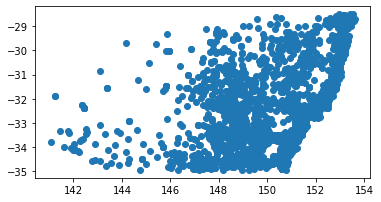

In [10]:
#Reading the json file
import json
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

with open('RFSStation_EPSG4326.json') as f:
  fire_stations = json.load(f)
f.close()


i = 0
data_length = len(fire_stations['RFSStation']['features'])
null_found = False

while i < data_length:
    if len(fire_stations['RFSStation']['features'][i]['geometry']['coordinates']) < 2:
        print("Null coordinates found")
        null_found = True
        
    i += 1

if not null_found:
    print("No Null Coordinates in this file. You're good to go!")
    
fireStation_df = gpd.GeoDataFrame.from_features(fire_stations['RFSStation'])
fireStation_df.plot()

#Creating table for firestations
conn.execute("DROP TABLE IF EXISTS rfsfirestations")

RFS_FireStations = """CREATE TABLE IF NOT EXISTS rfsfirestations (
                        coordinates GEOMETRY PRIMARY KEY,
                        stationid INTEGER, 
                        station_name VARCHAR(20)
                   )"""

try:
     conn.execute(RFS_FireStations)
     print("Successfully created table for fire_stations")

except Exception as e:
     print("Table not created.\n")
     print(e)
    
fireStation_df.to_postgis('rfsfirestations', conn, if_exists='replace')
res = pd.read_sql_query('SELECT * FROM rfsfirestations', conn)
res


# Joining the Table